# Exercise 1

For this exercise, we developed a BFR algorithm to cluster a dataset of music tracks. The implementation uses PySpark's DataFrame API in conjunction with Pandas's DataFrames.

## Imports

PySpark, Pandas, NumPy and Matplotlib are the non-standard libraries required.

In [1]:
import json
import pickle
import os.path
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType, ArrayType, DoubleType, IntegerType, StructField, StructType
from itertools import combinations
from typing import List, Set

import pandas as pd
import numpy as np
import numpy.typing as npt
from typing import Union

import matplotlib.pyplot as plt

## Spark initialization

Spark is initialized, with as many worker threads as logical cores on the machine. We did not use a fixed value since the machines used for development had a different number of CPU cores.

In [2]:
spark = SparkSession.builder \
    .appName('ClusteringBFR') \
    .config('spark.master', 'local[*]') \
    .getOrCreate()

23/05/04 17:21:53 WARN Utils: Your hostname, martinho-MS-7B86 resolves to a loopback address: 127.0.1.1; using 192.168.1.67 instead (on interface enp34s0)
23/05/04 17:21:53 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/04 17:21:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Prepare the data

The FMA dataset contains 2 files which we will mainly use, `tracks.csv` and `features.csv`.
The files `genres.csv` and `raw_genres.csv` are also used for visualizations at the end.

Both `tracks.csv` and `features.csv` had the need of some preprocessing on the column names due to having their headers divided in multiple levels defined in the first rows of the file.
The levels were separated with hyphens (`-`).

In order to remove the first few rows reserved for the column definitions, we performed a filtering operation.


`tracks.csv` is mainly used to obtain the IDs corresponding to the small subset of data, to then filter in the `features.csv` data.
It is also used when showing results at the end of the notebook, by verifying the genres present in the tracks of each cluster.

This file contains information about the album the track is in, some information about the artist of the track, title listens and etc.

In [3]:
tracks_df = (spark.read
    .option("multiline", "true")
    .option("quote", '"')
    .option("escape", '"')
    .csv('data/tracks.csv')
)

# rename columns with row values from first row to second row
column_categories = list(zip(*tracks_df.take(2)))
columns = tracks_df.columns
tracks_df = tracks_df.select(F.col(columns[0]).alias('track_id'),
    *(F.col(column).alias("-".join(map(str, categories)))
    for column, categories in zip(columns[1:], column_categories[1:]))
)

tracks_df = (tracks_df
    .filter(F.col("track_id").isNotNull()) 
    .filter(F.col("track_id") != "track_id")
)

tracks_df.show()

23/05/04 17:21:57 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------+--------------+-------------------+-------------------+--------------+---------------+--------+--------------------+-------------+--------------------+----------+--------------------+------------+----------------+------------------------+----------------------+------------------------+--------------------+---------------+-------------------+----------------+---------+---------------+------------------+----------------+--------------------+--------------------+-----------------------+--------------------+--------------------+---------------------+---------+----------+--------------+--------------+--------------+-------------------+-------------------+--------------+---------------+---------------+------------+-----------------+--------------------+--------------+-------------------+--------------------+-------------+--------------+------------+---------------+----------+--------------------+
|track_id|album-comments| album-date_created|album-date_released|album-engineer|album-

`features.csv` contains a list of 517 different features for each track. These features will be the ones used to cluster the tracks.
Each feature is in its own column, and it's cast to a double (`DoubleType`) for greater precision (we found `FloatType` had a disruptive amount of error).

In [4]:
features_df = (spark.read
    .csv('data/features.csv')
)

# rename columns with row values from first row to second row
column_categories = list(zip(*features_df.take(3)))
columns = features_df.columns
features_df = features_df.select(F.col(columns[0]).alias('track_id'),
    *(F.col(column).cast(DoubleType()).alias("-".join(map(str, categories)))
    for column, categories in zip(columns[1:], column_categories[1:]))
)

features_df = (features_df
    .filter(F.col("track_id") != "feature")
    .filter(F.col("track_id") != "statistics")
    .filter(F.col("track_id") != "number")
    .filter(F.col("track_id") != "track_id")
)

features_music_columns = features_df.columns.copy()
features_music_columns.remove('track_id')

## Agglomerative clustering (in-memory)

Before applying the BFR algorithm, we performed in-memory clustering of a small subset of the data (more specifically, agglomerative clustering). The goal is to get an idea for a good choice of the number of clusters and of the initial centroids before BFR clustering to the whole dataset.

For that, we need to extract from `tracks_df` only the rows belonging to the small subset as specified by the `set-subset` column.
With those rows, we join with the `features_df` dataframe to contain only features from those tracks (`left` join followed by a filter for the rows that did match).
We also collect the data from a PySpark dataframe to a Pandas dataframe to perform the in-memory computation.

In [5]:
dataset_subset_name = "small"

small_tracks_df = tracks_df.filter(F.col("set-subset") == dataset_subset_name)
small_features_df = (features_df
    .join(small_tracks_df, "track_id", "left")
    .filter(F.col("set-subset").isNotNull())
    .select(features_df.columns)
)

small_features_pd = small_features_df.toPandas()

To evaluate the clusters among themselves, the following function is used to calculate the metrics (radius, diameter, density with radius and density with diameter) for each cluster created from the agglomerative clustering.
We made use of NumPy's vectorized operations to apply the formulas for the metrics.
The input and output values are Pandas dataframes for integration with the `apply` Pandas method.

In [6]:
def calculate_metrics(pd_df: pd.DataFrame, centroids: npt.ArrayLike) -> pd.DataFrame:
    """Calculate the metrics (radius, diameter, density_r, density_d) for each cluster"""

    cluster = pd_df["cluster"].values[0]
    metrics = pd.DataFrame({'radius': [0], 'diameter': [0],'density_r': [0],'density_d': [0]}, columns=['radius', 'diameter','density_r','density_d'])
    centroid = centroids[cluster].reshape(1,-1)

    matrix = pd_df.drop(columns=["cluster", "track_id"]).to_numpy()
    
    matrix_radius = np.sqrt(np.sum((matrix - centroid)**2, axis=1))
    metrics.loc[0,'radius'] = np.max(matrix_radius)
    # calculate density with radius
    metrics.loc[0,'density_r'] = len(pd_df) / metrics.loc[0,'radius']**2

    for i in range(matrix.shape[0]):
        matrix_diameter = np.sqrt(np.sum((matrix[i:,:] - matrix[i,:])**2, axis=1))

        max_diameter = np.max(matrix_diameter)
        if max_diameter > metrics.loc[0,'diameter']:
            metrics.loc[0,'diameter'] = max_diameter
        
    # calculate density with diameter
    metrics.loc[0,'density_d'] = len(pd_df) / metrics.loc[0,'diameter']**2

    return metrics

For the agglomerative clustering, we used the implementation from `sklearn`. We also used their implementation of `NearestCentroid`, to obtain the centroids of each cluster to use in the calculation of the metrics for that cluster.

After performing the agglomerative clustering, we calculate the metrics by grouping the data according to the resulting clusters and then applied the previous metric calculation function within each cluster, resulting in a dataframe containing the metrics of each cluster.

For each clustering into $k$ clusters done (from $k=8$ to $k=16$) we save the metrics dataframes to an array which in the end is serialized with `pickle`, to avoid recalculating it in future runs.

In [7]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestCentroid
import numpy.typing as npt

n_clusters_range = range(8, 17)

metrics_pd_array = []

small_features_pd = pd.concat(objs=[small_features_pd, pd.DataFrame(data=np.zeros((len(small_features_pd), 1), dtype=np.int32), columns=["cluster"])], axis=1)

def cluster_agglomeratively(data: pd.DataFrame, n_clusters: int) -> npt.NDArray[np.float32]:
    if "cluster" not in data.columns:
        raise ValueError("The 'cluster' column should be present in the dataframe!")
    
    data_features_only = data.drop(columns=["cluster", "track_id"])

    clusterer = AgglomerativeClustering(n_clusters=n_clusters)
    clusterer.fit(data_features_only)
    
    centroid_calculator = NearestCentroid()
    centroid_calculator.fit(data_features_only, clusterer.labels_)

    data["cluster"] = clusterer.labels_
    return centroid_calculator.centroids_

if os.path.exists("./results/metrics_pd_array_pickle.pkl"):
    with open("./results/metrics_pd_array_pickle.pkl",'rb') as f:
        metrics_pd_array = pickle.load(f)

else:
    # i = 8 until 16
    for n_clusters in n_clusters_range:
        print(f"n_clusters: {n_clusters}")
        centroids = cluster_agglomeratively(small_features_pd, n_clusters)
        metrics_pd_array.append(small_features_pd.groupby("cluster").apply(calculate_metrics, centroids))

    # TODO: weird column at 0s without name??
    with open("./results/metrics_pd_array_pickle.pkl",'wb') as f:
        pickle.dump(metrics_pd_array, f)

### Clustering analysis

To compare the different number of clusters $k$, we printed the average and variance of each of the calculated density metrics, since it's those we are concerned with when assessing the quality of the clustering.

More specifically, we are mainly looking for high values for the average density, but low values for the density's variance are also desirable (we want most clusters to be dense and close to the average density).

In [8]:
for i in metrics_pd_array:
    density_r_average = i["density_r"].mean()
    density_d_average = i["density_d"].mean()
    density_r_variance = i["density_r"].var()
    density_d_variance = i["density_d"].var()

    print(f"Average density_r: {density_r_average}, Average density_d: {density_d_average}, Variance density_r: {density_r_variance}, Variance density_d: {density_d_variance}")
    print("\n")

Average density_r: 7.962110575648213e-05, Average density_d: 3.599342497079214e-05, Variance density_r: 7.554281742039276e-09, Variance density_d: 1.632545349816937e-09


Average density_r: 8.46827574451412e-05, Average density_d: 3.664885346147574e-05, Variance density_r: 7.747059677670204e-09, Variance density_d: 1.6211171070541367e-09


Average density_r: 8.164132830338627e-05, Average density_d: 3.4647549186503005e-05, Variance density_r: 7.052526954162877e-09, Variance density_d: 1.4927145547250588e-09


Average density_r: 7.530009483773654e-05, Average density_d: 3.330844689045004e-05, Variance density_r: 5.65147072510877e-09, Variance density_d: 1.2235780221208591e-09


Average density_r: 7.0833141687739e-05, Average density_d: 3.124377322263076e-05, Variance density_r: 5.389143411471879e-09, Variance density_d: 1.1658465305734218e-09


Average density_r: 6.755260440629955e-05, Average density_d: 2.980317784207617e-05, Variance density_r: 5.035928633263812e-09, Variance density_

We also plotted these averages on a heatmap plot for easier visualization.
For a better comparison among metric values, we computed the standard score within the values of each metric.

In [9]:
metrics_heatmap = np.array([
    [
        m["density_r"].mean(),
        m["density_d"].mean(),
        m["density_r"].var(),
        m["density_d"].var(),
    ]
    for m in metrics_pd_array
])

metrics_heatmap_standardized = (metrics_heatmap - metrics_heatmap.mean(axis=0)) / metrics_heatmap.std(axis=0)

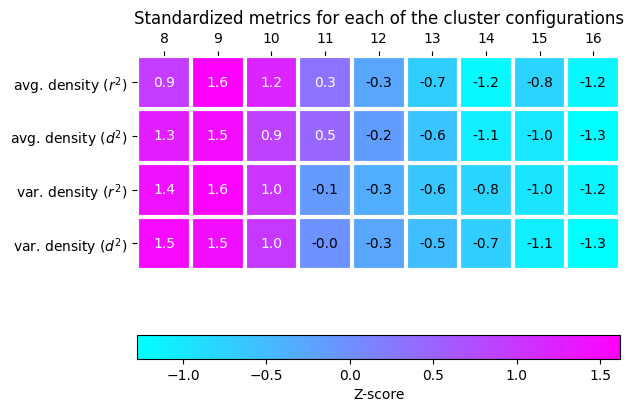

In [10]:
from plot_helpers import heatmap, annotate_heatmap

fig, ax = plt.subplots()

im, cbar = heatmap(
    data=metrics_heatmap_standardized.T,
    row_labels=["avg. density ($r^2$)", "avg. density ($d^2$)", "var. density ($r^2$)", "var. density ($d^2$)"],
    col_labels=list(map(str, n_clusters_range)),
    cbarlabel="Z-score",
    cbar_kw={"location": "bottom"},
    cmap="cool",
    ax=ax)
texts = annotate_heatmap(im, valfmt="{x:.1f}")

ax.set_title("Standardized metrics for each of the cluster configurations")

fig.tight_layout()

From these results, we decided to choose $k=9$ since it provided by far the greatest values for the average density.
Although it also provided a lot of variance, we notice this trend of high/low average density being related with high/low density variance for the other configurations as well.

## BFR Algorithm

### Parameters

We defined some parameters for the use of the BFR algorithm: 
- `n_clusters`: number of clusters to create (defined after the study of results from the small agglomerative clustering)

- `max_memory_used_bytes`: the maximum number of bytes of the dataset to collect into memory at once on each BFR cycle. This helps determine how many rows we should collect on each BFR cycle, by estimating the size of each row as being the sum of 8 bytes for each column, since they are `double`s.
  
- `cluster_distance_threshold`: the maximum distance a point should be to a cluster to be elegible to join the cluster (in terms of standard deviations considering the Mahalanobis distance)
  
- `compression_set_merge_variance_threshold`: the variance threshold used to merge two compression sets together, in terms of the maximum allowed variance of the merged set averaged along all dimensions, with respect to the greatest of this same value for each compression set that composes the merged one. For instance, a value of $\alpha$ for this threshold means that if $C_3 = C_1 + C_2$, i.e. $C_3$ is the result of merging $C_1$ and $C_2$, then the $C_3$'s variance averaged along all dimensions $\delta(C_3)$ should not be larger than $\alpha \cdot \max(\delta(C1), \delta(C2))$

We also import the `DBSCAN` implementation from sklearn, to cluster the remainder points into compression sets at each cycle of the algorithm, and also defined another parameter named `dbscan_eps`, which is the maximum distance between two samples for one to be considered as in the neighborhood of the other.

The values for each parameter were chosen experimentally, which provided a reasonable number of compression sets on each BFR cycle ($10 < n < 100$ for the most part) and an acceptable clustering by the end.

In [11]:
from sklearn.cluster import DBSCAN

n_clusters = 9

max_memory_used_bytes = int(.1e9)
# Assumes all columns are doubles/longs, therefore 8 bytes
rows_per_iteration = max_memory_used_bytes // (8 * len(features_df.columns))

seed_random = 0

# Threshold in terms of standard deviations away from centroid, in each dimension
cluster_distance_threshold_standard_deviations = 2
cluster_distance_threshold = ((cluster_distance_threshold_standard_deviations**2) * len(features_music_columns)) ** 0.5

compression_set_merge_variance_threshold = 1.001

dbscan_eps = 1000

### Initialize clusters

Firstly, to facilitate operations done in `discard` and `compression` sets, we defined a class called `SummarizedCluster`, which serves as a way to keep the summarized clusters organized inside the sets and contains the following atributes:

- `n`: number of points in this cluster 

- `sum_`: sum of the coordinates of the points in the cluster

- `sum_q`: sum of squares of the coordinates of the points in the cluster

- `id_`: ID of the cluster (an integer if it's a discard set, `None` for compression sets)

- `tracks`: set of track IDs of the points in this cluster, to know to which cluster each point belongs to

This class also has the functions to summarize a single point or multiple at the same time (provides better performance), as well as 3 functions to return the value of the centroid, variance and standart deviation.
The addition methods allow merging 2 summarized clusters.

In [12]:
import dataclasses

@dataclasses.dataclass(init=False)
class SummarizedCluster:
    n:      int                     
    sum_:   npt.NDArray[np.float64]
    sumsq_: npt.NDArray[np.float64]
    id_:    Union[int, None]
    tracks: Set[int]

    def __init__(self, dimensions: int, id_: int=None):
        self.n = 0
        self.sum_ = np.zeros((dimensions,), dtype=np.float64)
        self.sumsq_ = np.zeros((dimensions,), dtype=np.float64)
        self.id_ = id_
        self.tracks = set()
    
    def summarize(self, point: npt.NDArray[np.float64], track_id: int):
        self.n += 1
        self.sum_ += point
        self.sumsq_ += point**2
        self.tracks.add(track_id)
    
    def summarize_points(self, points: npt.NDArray[np.float64], track_ids: Set[int]):
        self.n += points.shape[0]
        self.sum_ += np.sum(points, axis=0)
        self.sumsq_ += np.sum(points**2, axis=0)
        self.tracks |= track_ids

    def centroid(self) -> npt.NDArray[np.float64]:
        return self.sum_ / self.n

    def variance(self) -> npt.NDArray[np.float64]:
        return (self.sumsq_ / self.n) - (self.sum_ / self.n)**2

    def standard_deviation(self) -> npt.NDArray[np.float64]:
        return np.sqrt(self.variance())

    def __add__(self, other: 'SummarizedCluster') -> 'SummarizedCluster':
        if not isinstance(other, SummarizedCluster):
            raise ValueError(f"Addition is not supported between a SummarizedCluster and a '{type(other)}'.")
        if self.id_ is not None and other.id_ is not None and self.id_ != self.other:
            raise ValueError(f"Clusters {self} and {other} have different explicit ids ({self.id_} != {other.id_}).")
        if self.tracks & other.tracks:
            raise ValueError(f"The clusters {self} and {other} overlap each other.")
        res = SummarizedCluster(self.sum_.size, self.id_ if self.id_ is not None else other.id_)
        res.n = self.n + other.n
        res.sum_ = self.sum_ + other.sum_
        res.sumsq_ = self.sumsq_ + other.sumsq_
        res.tracks = self.tracks | other.tracks
        return res

    def __iadd__(self, other: 'SummarizedCluster') -> 'SummarizedCluster':
        if not isinstance(other, SummarizedCluster):
            raise ValueError(f"Addition is not supported between a SummarizedCluster and a '{type(other)}'.")
        if self.id_ is not None and other.id_ is not None and self.id_ != self.other:
            raise ValueError(f"Clusters {self} and {other} have different explicit ids ({self.id_} != {other.id_}).")
        if self.tracks & other.tracks:
            raise ValueError(f"The clusters {self} and {other} overlap each other.")
        self.id_ = self.id_ if self.id_ is not None else other.id_
        self.n = self.n + other.n
        self.sum_ = self.sum_ + other.sum_
        self.sumsq_ = self.sumsq_ + other.sumsq_
        self.tracks = self.tracks | other.tracks
        return self

    def __str__(self) -> str:
        return f'SummarizedCluster({self.id_}, n={self.n})'

    def __repr__(self) -> str:
        return str(self)

Before initializing the loop, we need to create the sets:

- `Discard sets`: the $k$ clusters we initialized. Points go to these clusters if they are sufficiently close to one of their centroid

- `Compression sets`: groups of points close together, but not close enough to a discard set. Will be built throughout the execution of the algorithm

- `Retained set`: isolated points not belonging to a discard or compression set, yet. A Pandas dataframe for easy integration into the calculations performed at each cycle of the BFR algorithm (a features dataframe is collected at each cycle, which has to be concatenated with the retained points when clustering for generating compression sets)

In [13]:
discard_sets: List[SummarizedCluster] = [SummarizedCluster(len(features_music_columns), id_) for id_ in range(n_clusters)]
compression_sets: List[SummarizedCluster] = []
retained_set: pd.DataFrame = pd.DataFrame(data=[], columns=features_df.columns)

For Step 1 of the algorithm, we first need to initialize our $k$ clusters.
For this, we use the clusters generated with the small subset of tracks used in the agglomerative clustering section.

Note: the `small_features_pd` is altered in-place, and will include the `cluster` column after execution of the function.

In [14]:
cluster_agglomeratively(small_features_pd, n_clusters)

array([[ 7.83675088e-02,  5.16735226e-02,  1.59382809e-01, ...,
         5.30067748e-03,  2.07549786e+00,  4.33664054e-02],
       [ 1.03361790e-01, -1.10108954e-02,  8.66843957e-02, ...,
         1.81640625e-03,  4.48035001e+00,  2.56862845e-02],
       [-2.28107039e-04,  4.63624385e-02,  1.61303272e+00, ...,
         4.52972740e-03,  1.93264725e+00,  2.37264543e-02],
       ...,
       [ 1.20322789e-01, -3.89450201e-02,  8.12033925e-02, ...,
         1.93734005e-03,  4.22999891e+00,  7.36356004e-02],
       [ 5.46471115e-02, -7.16064944e-02,  1.36816759e-01, ...,
         2.96972879e-03,  3.37820637e+00,  2.63650550e-02],
       [ 2.07175936e-01,  1.27873661e-01,  2.10691641e-01, ...,
         1.42632504e-03,  2.17195249e+00,  4.97517727e-02]])

After clustering the small subset, we can initialize the discard sets with the points belonging to this subset.
For that we apply a Pandas function to each cluster, summarizing all points of each cluster into their respective discard set, indexed by the cluster ID.
The Pandas function modifies the discard sets in-place.

In [15]:
def summarize_cluster_df(cluster_df: pd.DataFrame) -> None:
    cluster_id = cluster_df["cluster"].values[0]
    cluster_features_mtx = cluster_df.drop(columns=["cluster", "track_id"]).to_numpy()
    
    track_ids = set(cluster_df["track_id"].values)

    discard_set = discard_sets[cluster_id]
    discard_set.summarize_points(cluster_features_mtx, track_ids)

small_features_pd.groupby("cluster").apply(summarize_cluster_df)

""


### Loop

After summarizing the points of the small subset, we remove them from the features Spark dataframe.

Then, we randomly split the features dataframe into evenly-sized parts (or similarly-sized parts at least), to load points into memory in chunks at each BFR cycle.

In [16]:
features_without_small_df = (features_df
    .join(small_tracks_df, "track_id", "left")
    .filter(F.col("set-subset").isNull())
    .select(features_df.columns)
)

total_rows = features_without_small_df.count()
split_weights = [1.0] * (1 + (total_rows // rows_per_iteration))

# Non-overlapping on local master, manually tested
split_dfs = features_without_small_df.randomSplit(split_weights, seed=seed_random)

Before starting with the BFR loop, we developed a function to assign a discard set ID to each point in a set of points loaded into memory.

Firstly, we add all necessary columns for assigning discard sets (to avoid adding many columns in runtime, for performance):
- `cluster_distance_X`: a column for each cluster, containing the distance of the point to cluster `X`

- `min_cluster_distance`: the minimum value of `cluster_distance_X` for all `X`

- `cluster_id`: the discard set ID

Then we calculate the Mahalonobis distance of each point to each cluster, and afterwards store the lowest distance for each point.
Finally, the cluster ID is set to the index of the closest cluster.

Lastly, if the `min_cluster_distance` is higher than the threshold defined (`cluster_distance_threshold`), we redefine the cluster id column to `-1`, to identify this point as an outlier with no assigned cluster/discard set.

In [17]:
def mahalanobis_distance_pd(x: pd.DataFrame, s: SummarizedCluster) -> pd.Series:
    return (((x - s.centroid()) / s.standard_deviation())**2).sum(axis=1) ** 0.5

def assign_discard_sets(loaded_points_pd: pd.DataFrame):
    prefix = "cluster_distance_"
    cluster_distance_columns = [f"{prefix}{i}" for i in range(n_clusters)]

    loaded_points_pd = pd.concat(
        objs=[loaded_points_pd, pd.DataFrame(
            data=np.zeros((loaded_points_pd.shape[0], len(cluster_distance_columns) + 2)),
            columns=cluster_distance_columns + ['min_cluster_distance', 'cluster_id'])],
        axis=1
    )

    for i, discard_set in enumerate(discard_sets):
        loaded_points_pd[f"cluster_distance_{i}"] = mahalanobis_distance_pd(loaded_points_pd[features_music_columns], discard_set)
    loaded_points_pd["min_cluster_distance"] = loaded_points_pd[cluster_distance_columns].min(axis=1)
    loaded_points_pd["cluster_id"] = loaded_points_pd[cluster_distance_columns].idxmin(axis=1).str.slice(start=len(prefix)).astype(np.int32)

    loaded_points_pd.drop(columns=cluster_distance_columns, inplace=True)

    # Don't consider the points that surpass the threshold for the discard sets
    loaded_points_pd.loc[loaded_points_pd["min_cluster_distance"] >= cluster_distance_threshold, "cluster_id"] = -1
    loaded_points_pd.drop(columns=["min_cluster_distance"], inplace=True)

    return loaded_points_pd

After initializing the $k$ clusters, we need to implement the Steps 2-6 in a loop to complete the BFR algorithm.

- **Step 2**: As previously stated, we divided the points into separate dataframes, to load only a small portion of points at the same time.
This small dataframe of points is collected into memory as a Pandas dataframe.

- **Step 3**: Then we use the previously defined `assign_discard_sets` function, which will add the `cluster_id` to each track in the Pandas dataframe.
We execute a `for` loop, iterating for every cluster assigned by the function.
All points belonging to each cluster are added to the corresponding discard set.
The exception is for the points with `cluster_id == -1`, which are dealt with in the next step.

- **Step 4**: Now, having the leftover points after Step 3, we use `DBSCAN` to execute the clustering of these points.
This implementation was chosen due to the fact that it already excludes some points if they are not considered close to a cluster enough (noise points). This enables us to create compression sets (one for each cluster) and also keep some points (the noise points) to add in the retained set.
After creating the compression sets, its points are summarized and them these sets are added to the list of compression sets previously created.

- **Step 5**: After creating some compression sets, we try to merge them pairwise. These are merged if the mean variance of the merged set is not larger than the maximum mean variance of the originating sets within an error defined by the merge threshold. This is dependent on the order that the compression sets are iterated on (early merges are prioritized), and is performed constantly until no more merges can be done.

In [18]:
def print_progress(progress: float, message: str):
    print(f"[{progress:2%}] {message:100}", end="\r")

print_progress(0, "Initialized BFR")

for split_idx, loaded_points_df in enumerate(split_dfs):
    progress = split_idx / len(split_weights)
    
    print_progress(progress, "Collecting split into memory...")
    loaded_points_pd = loaded_points_df.toPandas()

    print_progress(progress, "Clustering with the Mahalanobis distance...")  
    loaded_points_pd = assign_discard_sets(loaded_points_pd)
    
    print_progress(progress, "Calculated and collected Mahalanobis distances")

    for cluster_id, cluster_pd in loaded_points_pd.groupby("cluster_id"):
        track_ids = cluster_pd["track_id"]
        features_list = cluster_pd[features_music_columns]

        print_progress(progress, f"Evaluating cluster {cluster_id}...")

        # Step 3 - check which points go to the discard sets
        if cluster_id != -1:
            discard_set = discard_sets[cluster_id]
            discard_set.summarize_points(features_list, set(track_ids))
        
        # Step 4 - check which points go to the compression sets or the retained set
        else:
            cluster_with_retained_pd = pd.concat(objs=[cluster_pd, retained_set], axis=0)

            # Use same distance as above
            clusterer = DBSCAN(eps=dbscan_eps, metric='euclidean')
            clusterer.fit(cluster_with_retained_pd[features_music_columns])

            retained_set = cluster_with_retained_pd[clusterer.labels_ == -1]

            mini_clusters = set(clusterer.labels_) - {-1}

            # Create compression sets
            compression_sets_temp = [SummarizedCluster(len(features_music_columns), None) for _ in mini_clusters]
            for mini_cluster_id in mini_clusters:
                compression_sets_temp[mini_cluster_id].summarize_points(
                    cluster_with_retained_pd[features_music_columns][clusterer.labels_ == mini_cluster_id], 
                    set(cluster_with_retained_pd['track_id'][clusterer.labels_ == mini_cluster_id])
                )
            
            compression_sets.extend(compression_sets_temp)
        
    print_progress(progress, f"Finished evaluating clusters (compression sets: {len(compression_sets)}, retained set: {len(retained_set)})")

    # Step 5 - merge compression sets
    compressing = True
    while compressing:
        compressing = False
        merged_compression_sets = []
        compression_set_idxs_to_remove = set()

        for (idx_1, compression_set_1), (idx_2, compression_set_2) in combinations(enumerate(compression_sets), 2):
            if idx_1 in compression_set_idxs_to_remove or idx_2 in compression_set_idxs_to_remove:
                continue

            merged_compression_set = compression_set_1 + compression_set_2
            if merged_compression_set.variance().mean() < compression_set_merge_variance_threshold * max(compression_set_1.variance().mean(), compression_set_2.variance().mean()):
                merged_compression_sets.append(merged_compression_set)
                compression_set_idxs_to_remove.add(idx_1)
                compression_set_idxs_to_remove.add(idx_2)
                compressing = True
        
        compression_sets: List[SummarizedCluster] = [cs for i, cs in enumerate(compression_sets) if i not in compression_set_idxs_to_remove]
        compression_sets.extend(merged_compression_sets)

        print_progress(progress, f"Completed one compression (compression sets: {len(compression_sets)})")
    
    print_progress((split_idx + 1) / len(split_weights), f"Finished one of the splits (compression sets: {len(compression_sets)}, retained set: {len(retained_set)})")
    print()

[20.000000%] Finished one of the splits (compression sets: 1, retained set: 180)                                 


[40.000000%] Finished one of the splits (compression sets: 3, retained set: 399)                                 


[60.000000%] Finished one of the splits (compression sets: 15, retained set: 535)                                


[80.000000%] Finished one of the splits (compression sets: 24, retained set: 664)                                


[100.000000%] Finished one of the splits (compression sets: 33, retained set: 818)                                


- **Step 6**: Lastly, we decide which discard set is closest to each compression set at the end and merge them together, leaving the points contained in the retained set as outliers for further analysis.

In [19]:
# Step 6 - merge CS into DS, leave RS out for further analysis
compression_sets_closest_discard = [
    (cs, min(((ds.id_, np.sqrt(np.sum(np.square(cs.centroid() - ds.centroid())))) for ds in discard_sets), key=lambda t: t[1])[0])
    for cs in compression_sets
]

old_discard_sets = discard_sets.copy()
for cs, ds_id in compression_sets_closest_discard:
    discard_sets[ds_id] = cs + discard_sets[ds_id]

## BFR cluster visualization

To visualize the cohesiveness of each cluster, we decided to analyze which music genres compose each cluster.
For that, we make use of the track information in `tracks.csv`, which already contains some information on the genres of each track.

The genres are laid out in a tree, with genres possibly having sub-genres.
For brevity, we are only interested in analyzing the root genres (not sub-genres), contained in the column `track-genre_top`.
However, most of the tracks don't have a single root genre assigned to them (`null` value), since they have multiple possible roots (evidenced by the `tracks-genres_all` column, which contains all genres assigned explicitly and implicitly).

In [20]:
print(f"Portion of tracks with a null root genre: {tracks_df.filter(F.col('track-genre_top').isNull()).count() / tracks_df.count():%}")

Portion of tracks with a null root genre: 53.461445%


Therefore, for visualization, we will allow each track to be represented by multiple root genres.
We load both CSVs pertaining to the genres, since `genres.csv` provides the proper root genre information while `raw_genres.csv` provides an already assigned color for each genre, which helps in the visualization.

In [21]:
genres_df = spark.read.option('header', 'true').csv('./data/genres.csv')
genres_colors_df = spark.read.option('header', 'true').csv('./data/raw_genres.csv')

From these dataframes, we obtain the genres' labels and their respective colors, considering only the root genres (`parent == 0`).
The genre labels are sorted by the genre ID to avoid the possibility of having consecutive colors that are too similar and thus complicate the visualization of the clusters (the dataset seems to assign consecutive genres with colors that are distinct enough).

In [22]:
genres = [row["title"] for row in genres_df.filter(F.col('parent') == 0).sort(F.col('genre_id').cast(IntegerType())).select('title').collect()]
genres_colors = {row["title"]:row["genre_color"] for row in genres_df.filter(F.col('parent') == 0).join(genres_colors_df, on='genre_id', how='inner').collect()}

Now, to assign the dataset points to each discard set, we create a Spark dataframe containing the assignment of each track to the respective discard set's ID.
This dataframe will then be joined with the `tracks_df` dataframe to add the `cluster_id` column.
This is far more performant than filtering `tracks_df` using `set` membership queries.

In [23]:
cluster_assignment_df = spark.createDataFrame(
    data=[(track, ds.id_) for ds in discard_sets for track in ds.tracks],
    schema=StructType([StructField('track_id', StringType(), False), StructField('cluster_id', IntegerType(), False)])
)

Finally, we assign for each discard set a Python dictionary containing the number of tracks for each genre contained at least once in that discard set.
We also consider the cluster ID of `None`, which signifies the leftover points that weren't assigned to a discard set (retained set).

To consider multiple root genres, we ignore the `track-genres_top` column and create one manually. 
We explode the list of genres to which each track belongs to (values could not be cast to `ArrayType`, but are JSON serializable), creating multiple rows with the different `genre_id`s assigned to each track.
We join with the filtered `genres_df` in order to only contain the rows with root genres and extract the genre's title as well.

Then, we join with `cluster_assignment_df`, obtaining the column `cluster_id` with the discard set the track belongs to or `null` if it doesn't belong to a discard set, since the join is `left`.
Finally, we obtain the counts for each genre using a `groupby`-`aggregate` operation, and finally `groupby` according to the cluster in order to create a `map` of the genres to their counts for each cluster.

We also create another structure, `genre_counts`, which is a "transposed" version of the previously described structure (`genre_counts_for_each_discard_set`), containing for each genre its counts on each cluster as an array.
This is helpful when plotting the graphs ahead.

In [24]:
cluster_ids = [None] + list(range(n_clusters))

to_list = F.udf(lambda s: json.loads(s), ArrayType(StringType(), False))

genre_counts_for_each_discard_set = {
    row['cluster_id']:row['genre_counts']
    for row in (tracks_df
        .select('track_id', F.explode(to_list('track-genres_all')).alias('genre_id'))
        .join(genres_df
            .filter(F.col('parent') == 0)
            .select('genre_id', F.col('title').alias('genre_title')),
            on='genre_id',
            how='inner')
        .drop('genre_id')
        .join(cluster_assignment_df, on='track_id', how='left')
        .select('track_id', 'cluster_id', 'genre_title')
        .groupby('cluster_id', 'genre_title')
        .agg(F.count('track_id').alias('count'))
        .groupby('cluster_id')
        .agg(F.map_from_arrays(F.collect_list('genre_title'), F.collect_list('count')).alias('genre_counts'))
    ).collect()
}

genre_counts = {
    genre:np.array([(genre_counts_for_each_discard_set[cluster_id][genre] if genre in genre_counts_for_each_discard_set[cluster_id] else 0) for cluster_id in cluster_ids])
    for genre in genres
}

One of the graphs we created was a bar plot showing the overall number of tracks of each genre on each cluster.

We can notice that the clusters aren't homogeneous, containing a variety of genres.
However, it can be noted that some genres may appear significantly in only a few clusters (`Instrumental`/`Classical` in cluster 1, `Hip-Hop` in clusters 1 and 4, etc.), suggesting some genres had musical features distinct enough to be mostly considered in only one or few clusters.

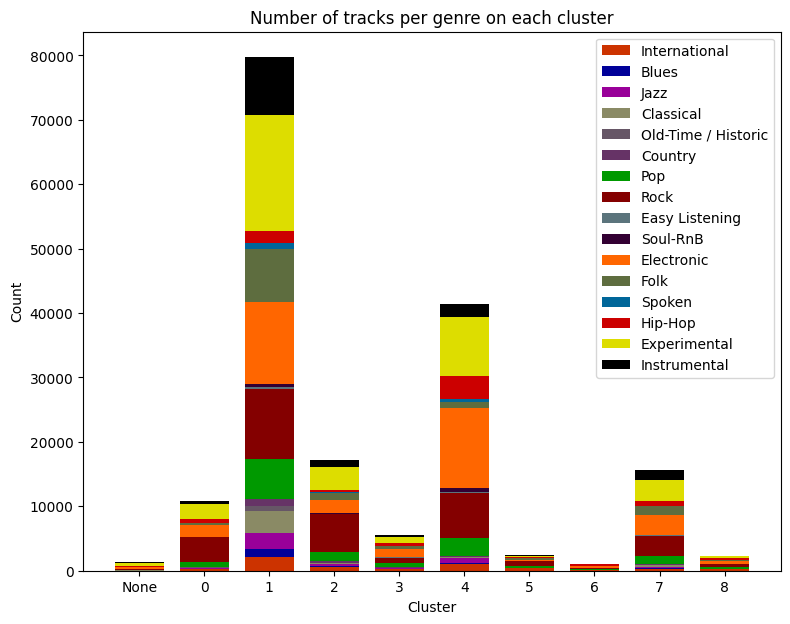

In [25]:
width = 0.75

fig, ax = plt.subplots(figsize=(9, 7))
bottom = np.zeros(n_clusters + 1) # include the outliers

cluster_ids_xs = [-1] + list(range(n_clusters))

for genre in genres:
    p = ax.bar(cluster_ids_xs, genre_counts[genre], width, label=genre, bottom=bottom, color=genres_colors[genre])
    bottom += genre_counts[genre]

ax.set_title("Number of tracks per genre on each cluster")
ax.legend(loc="upper right", fontsize=10)
ax.set_xlabel("Cluster")
ax.set_ylabel("Count")
ax.set_xticks(ticks=cluster_ids_xs, labels=map(str, cluster_ids))

float_to_fname = lambda f: str(f).replace('.', '-')
fig.savefig(f'./results/graphs/clustering_number_c{n_clusters}_std{float_to_fname(cluster_distance_threshold_standard_deviations)}_mvt{float_to_fname(compression_set_merge_variance_threshold)}_eps{float_to_fname(dbscan_eps)}.png')

We also analyzed the top 3 genres of each cluster, by checking how much of the top 3 they make a portion of.
Two structures were created similar to `genre_counts_for_each_discard_set` and `genre_counts`, but this time only considering the top 3 genres with the genre counts being instead fractions of the top 3.

In [26]:
genre_counts_for_each_discard_set_top_3_portions = {
    discard_set:sorted(counts.items(), key=lambda t: t[1], reverse=True)[:3]
    for discard_set, counts in genre_counts_for_each_discard_set.items()
}

genre_counts_for_each_discard_set_top_3_portions = {
    discard_set:[(genre, count / sum(count for _, count in top_3)) for genre, count in top_3]
    for discard_set, top_3 in genre_counts_for_each_discard_set_top_3_portions.items()
}

genre_counts_top_3 = {}
for discard_set, top_3 in genre_counts_for_each_discard_set_top_3_portions.items():
    for genre, portion in top_3:
        discard_portions = genre_counts_top_3.setdefault(genre, np.zeros((n_clusters + 1,)))
        if discard_set is None:
            discard_portions[0] = portion
        else:
            discard_portions[discard_set + 1] = portion

We can notice that the genres `Experimental`, `Electronic` and `Rock` are present in practically all of the top 3s, which can be related with the fact that these genres are present in many of the dataset's tracks, but also that the music features provided could not easily distinguish between these genres at all.

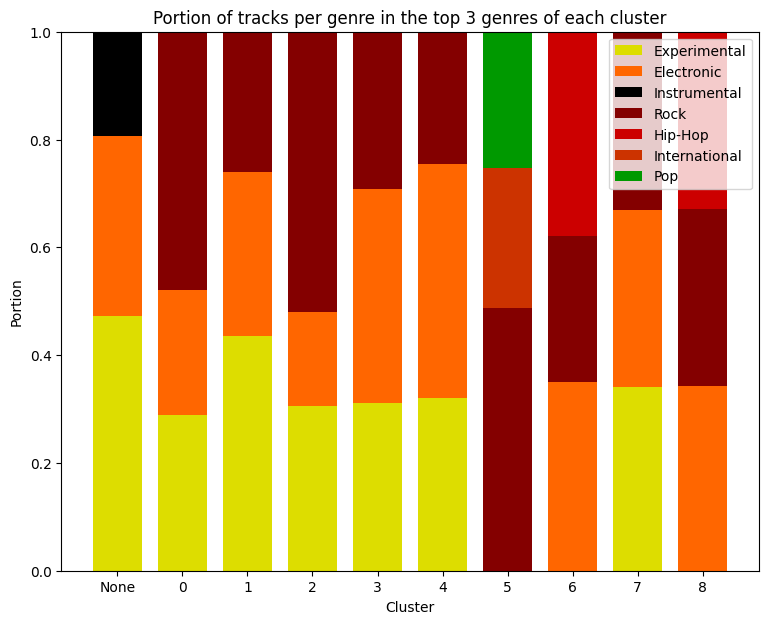

In [27]:
width = 0.75

fig, ax = plt.subplots(figsize=(9, 7))
bottom = np.zeros(n_clusters + 1) # include the outliers

cluster_ids_xs = [-1] + list(range(n_clusters))

for genre, portions in genre_counts_top_3.items():
    p = ax.bar(cluster_ids_xs, portions, width, label=genre, bottom=bottom, color=genres_colors[genre])
    bottom += portions

ax.set_title("Portion of tracks per genre in the top 3 genres of each cluster")
ax.legend(loc="upper right", fontsize=10)
ax.set_xlabel("Cluster")
ax.set_ylabel("Portion")
ax.set_xticks(ticks=cluster_ids_xs, labels=map(str, cluster_ids))

float_to_fname = lambda f: str(f).replace('.', '-')
fig.savefig(f'./results/graphs/clustering_portion_c{n_clusters}_std{float_to_fname(cluster_distance_threshold_standard_deviations)}_mvt{float_to_fname(compression_set_merge_variance_threshold)}_eps{float_to_fname(dbscan_eps)}.png')